In [83]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime

## Group Assignment
### Team Number: 13
### Team Member Names: Jaimin Patel, Frank Lin, Elliot Nou
### Team Strategy Chosen: Market Meet

# Preliminary Filtering

In [84]:
# Obtain latest USD to CAD conversion rate
fx = yf.download("USDCAD=X", period="5d")["Close"].dropna()
CAD_PER_USD = float(fx.iloc[-1])

def read_csv(filename):
    data = pd.read_csv(filename, header=None)
    l= data.values.tolist()
    list=[]
    for i in l:
        list.append(i[0])
    return list
    
# Checks each ticker to determine if it is valid or invalid based on data availability,
# trading volume, and market listing. It returns two lists: valid_tickers and invalid_tickers
# Function that checks every ticker to determine if it is valid or invalid 
# It returns two lists: valid_tickers and invalid_tickers   
def check_ticker(list):
    valid_tickers=[]
    invalid_tickers=[]
    start = "2024-10-01"
    end="2025-09-30"
    # Retrieve S&P 500 history (used to validate data availability)
    market = yf.Ticker("^GSPC")
    market_data = market.history(start=start, end=end, interval="1d")
    market_data["Market_Return"] = market_data["Close"].pct_change()

    info_cache = {}
    for ticker in list:
        # If there is a duplicate ticker in the csv file that is already validified, skip over it
        if ticker in valid_tickers:
            continue
        
        stock = yf.Ticker(ticker)
        data = stock.history(start=start, end=end, interval="1d")

        # If there's no historical price data that exists, the stock is marked as invalid
        if data.empty:
            invalid_tickers.append(ticker)
            continue

        avg_volume = data["Volume"].mean()

        # If the volume of the ticker is less than 5000, the ticker is considered invalid
        if avg_volume < 5000:
            invalid_tickers.append(ticker)
            continue
        try:
            if ticker not in info_cache:
                info_cache[ticker] = stock.get_info()
            market_of_ticker = info_cache[ticker].get("market")
        except Exception:
            market_of_ticker = None
        
        if market_of_ticker not in ["us_market", "ca_market"]:
            invalid_tickers.append(ticker)
            continue

        valid_tickers.append(ticker)

    return valid_tickers, invalid_tickers

# Calculates the combined benchmark of both S&P 500 and TSX, creating a blended benchmark
def blended_benchmark(start, end):
    data = yf.download(["^GSPC", "^GSPTSE"], start=start, end=end)["Close"]
    blended_price = 0.5 * data["^GSPC"] + 0.5 * data["^GSPTSE"]
    returns = blended_price.pct_change().dropna()
    return returns.rename("Benchmark")

/var/folders/fp/yttkjwks0hqdpssrf8qtp_wc0000gn/T/ipykernel_87268/20388546.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx = yf.download("USDCAD=X", period="5d")["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/var/folders/fp/yttkjwks0hqdpssrf8qtp_wc0000gn/T/ipykernel_87268/20388546.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  CAD_PER_USD = float(fx.iloc[-1])


# Main Approach

## Measurements

Each stock will be assigned a score based on three factors: annualized volatility ratio, Beta coefficient, and correlation.

Firstly, the **annualized volatility** of the stocks will be measured, and its ratio to the benchmark volatility will be incorporated into the scoring system. We deemed this measure important, as stocks that are too volatile or too calm could either overreact or underreact to benchmark movements during the contest period. Further, we chose annualized volatility over daily volatility cause annualization creates a smoother, more reliable standard of comparison. This, however, leads to a major issue -- the fluctuations may be asynchronous, i.e., the stock may have a volatility that is numerically similar to the benchmark’s, yet move in opposite directions. In a 1-week period this is dangerous: matched volatility with opposite movement can amplify deviations, worsening performance altogether.

To address this issue, we considered another measure: the **Beta coefficient ($\beta$)**. The beta of a stock is a direct measure of how similarly a stock's returns move with the market. They are "the dominant drivers of portfolio-level systematic risk" and understanding it is crucial for portfolio construction (Briand, Nielsen, & Stefek, 2009). The equation for beta is as follows:

$$
\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}
$$


where $R_i$ is the daily return of stock i, and $R_m$ is the daily return of our benchmark. 

Beta can yield a range of values:


-  $\beta < 0$: The covariance of $R_i$ and $R_m$ is negative. This means the that the stock moves in the opposite direction of the market: -- the worst-case scenario for a market-meet strategy.
- $0 < \beta < 1$: The covariance of $R_i$ and $R_m$ is smaller than the variance of $R_m$. The stock moves in the same direction as the market, but with weaker intensity. This is undesirable over a 1-week period because the stock lags behind the benchmark's movement and cannot self-correct within such a brief window of time.
-  $\beta > 1$: The stock moves in the same direction a the market but this time with too much intensity. This causes the portfolio to be overly sensitive during the 1-week period making it likely to overshoot/undershoot.
-  $\beta \approx 1$: This means the stocks covariance with the market is roughly equal to the market's own variance, indicating the most stable and consistent behaviour.

Thus, the stocks with a $\beta$ close to 1 will be rewarded a higher score.

While $\beta$ provides insight into the average sensitivity of a stock to market movements within a set time frame, it cannot fully describe the consistency of its movement from day to day. A stocks can have a  $\beta$ close to 1 but behave very differently from the benchmark in the short-term. For instance, consider the price movement of the stock NIO compared to the scaled benchmark in a 1-year time period:

[*********************100%***********************]  3 of 3 completed
/var/folders/fp/yttkjwks0hqdpssrf8qtp_wc0000gn/T/ipykernel_87268/20388546.py:64: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(["^GSPC", "^GSPTSE"], start=start, end=end)["Close"]
[*********************100%***********************]  2 of 2 completed

NIO 1-year beta: 1.181
NIO 1-year correlation: 0.266



/var/folders/fp/yttkjwks0hqdpssrf8qtp_wc0000gn/T/ipykernel_87268/20388546.py:66: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = blended_price.pct_change().dropna()
/var/folders/fp/yttkjwks0hqdpssrf8qtp_wc0000gn/T/ipykernel_87268/698805552.py:19: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  nio_returns = compare["NIO"].pct_change().dropna()


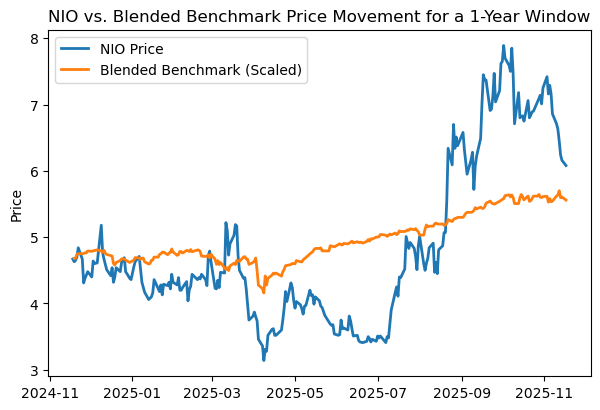

In [85]:
compare = yf.download(["NIO", "^GSPC", "^GSPTSE"], start="2024-11-18", end="2025-11-18", auto_adjust=True)["Close"]
nio_price = compare["NIO"].dropna()

benchmark = blended_benchmark("2024-11-18", "2025-11-18")
benchmark_index = (1 + benchmark).cumprod()

# The benchmark is scaled to match NIO's starting price, as we only care about their relative movements.
nio_start = nio_price.iloc[0]
benchmark_scaled = benchmark_index * nio_price.iloc[0]

plt.figure(figsize=(7, 4.5))
plt.plot(nio_price, label="NIO Price", lw=2)
plt.plot(benchmark_scaled, label="Blended Benchmark (Scaled)", lw=2)
plt.title("NIO vs. Blended Benchmark Price Movement for a 1-Year Window")
plt.ylabel("Price")
plt.legend()

# Calculates NIO's beta and correlation to the blended benchmark
nio_returns = compare["NIO"].pct_change().dropna()
aligned = pd.concat([nio_returns, benchmark], axis=1).dropna()
aligned.columns = ["NIO_Returns", "Benchmark"]

beta = aligned["NIO_Returns"].cov(aligned["Benchmark"]) / aligned["Benchmark"].var()
correlation = aligned["NIO_Returns"].corr(aligned["Benchmark"])

print("NIO 1-year beta:", np.round(beta, 3))
print("NIO 1-year correlation:", np.round(correlation, 3))

From the beta and correlation calculations over the 1 year, NIO has a reasonably desirable beta (1.181) but a low correlation with the blended benchmark (0.266). When plotting NIO's price next to the scaled benchmark, this misalignment becomes pronounced: during the 1 year, the two lines frequently diverge, and NIO often rises and falls in directions that appear to behave independently from the benchmark.

To mitigate this, we will incorporate a final measure, **correlation**, into the scoring system. Correlation returns the consistency and direcitonal accuracy of the day-to-day comovements, hence serves as a good complement to address the shortcomings of both beta and volatility. It safeguards our final portfolio from the following scenarios:
- Similar volatility but opposite direction
- Beta close to 1 but noisy/inconsistent path
- Lagged reactions stocks have to benchmark changes (especially disastrous for a 1-week time frame)

On the converse, beta and volatility address the shortcomings of correlation: its inability to depict the  *magnitude* of movement.

All-in-all, we concluded that these three measures complement one another effectively, and that a carefully calibrated combination will provide a robust way to identify stocks that are most likely move in line with the benchmark over a 1-week period. 

## Time frame for calculating chosen metrics

When calculating each stock's metrics for our scoring system, we are now faced with the issue of choosing a specific historical window over which beta, volatility, and correlation of our stocks are measured. This cannot be random: the time period must reflect the current economic environment, meanwhile providing enough data for statistically reliable estimates. A poorly chosen window can distort every metric. We considered a recent six-month window, from 2025-05-15 to 2025-11-15. A 6-month period offers a balance between stability and recency. Our beta and correlation calculations rely on a 30-day rolling window, and thus a six-month range provides multiple overlapping windows for averaging. This reduces noise and inaccurate calculations arising from a small sample size.

Considering the economic context of this period, markets were operating under monetary policy stabilization. Both the Federal Reserve and the Bank of Canada entered 2024-2025 signalling an end to reduced interest-rate hikes and volatility. By mid-2025, the US inflation rate had fallen into the 2.5%-3.0% range (U.S. Bureau of Labor Statistics, 2025), while Canadian CPI had declined to approximately 2.7% (Statistics Canada, 2025). Stable macroeconomic conditions tend to strengthen the reliability of systematic factors like beta (Leote de Carvalho, Xiao, & Moulin, 2014).

Furthermore, there were no major macroeconomic events during this period.

To better observe the behaviour of the market during this period, the benchmark average returns are plotted below, and its annualized volatility is calculated.

/var/folders/fp/yttkjwks0hqdpssrf8qtp_wc0000gn/T/ipykernel_87268/3605962133.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(["^GSPC", "^GSPTSE"], start="2025-05-15", end="2025-11-15")["Close"]
[*********************100%***********************]  2 of 2 completed


Annualized Benchmark Volatility: 9.049%


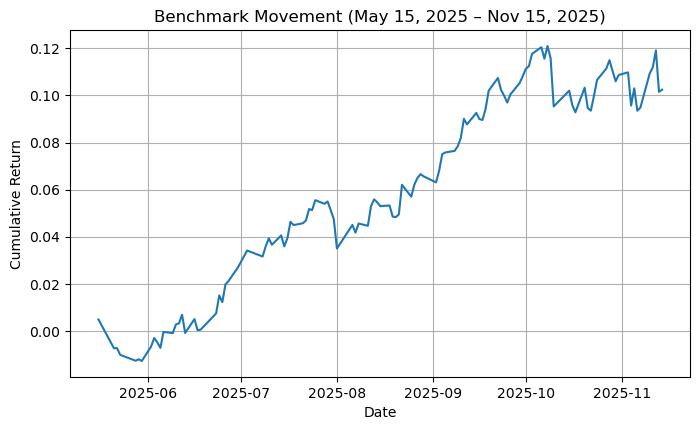

In [86]:
data = yf.download(["^GSPC", "^GSPTSE"], start="2025-05-15", end="2025-11-15")["Close"]

rets = data.pct_change(fill_method=None).dropna()
bench = rets.mean(axis=1)

plt.figure(figsize=(8,4.5))
plt.plot(bench.index, bench.cumsum())
plt.title("Benchmark Movement (May 15, 2025 – Nov 15, 2025)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)

volatility = bench.std()*np.sqrt(252)
print("Annualized Benchmark Volatility: ", round(volatility*100, 3), "%", sep='')


As expected, we obtain a low annualized volatility of 9.05%, indicating a stable market.
Therefore, the date range of 2025-05-15 to 2025-11-15 (reflected in the code below) is intentionally employed.

## [CODE] Calculating Metrics

In [87]:
# Function that takes a list of valid tickers + sets time range
def score_data(valid_tickers):
    start="2025-05-15"
    end="2025-11-15"

# Retrieves the sector from yfinance 
    def get_sector_safe(ticker):
        try:
            info = yf.Ticker(ticker).get_info()  # Retrieves a dictionary of data from the company
    
        except Exception:    # This makes sure that if theres missing data or any errors, we run an empty dictionary instead of just crashing 
            info = {}
        sector = ( 
            info.get("sector")
            or info.get("industry")
            or info.get("categoryName")
            or "Unknown"
        )
        # Returns the best available sector field 
        # Will move onto industry if there's no sector for example
        return sector 

    # Empty lists to store results for each ticker then generates the blended benchmark
    valid_stocks_with_data = []
    bench = blended_benchmark(start, end)

# Formula for converting the daily volatility to the annual volatility
    bench_vol_ann = float(bench.std() * np.sqrt(252))
    if bench_vol_ann <= 0 or not np.isfinite(bench_vol_ann):
        bench_vol_ann = bench.std() * np.sqrt(252) # If the value is invalid, it's replaced with np.nan
   
    # Sets the number of days in the rolling window (as we have a rolling beta and rolling correlation)
    # to make getting recent data easier
    window = 30


    # Looping through all valid tickers and extracting daily returns
    for i in valid_tickers:
        stock_ret = yf.download(i, start=start, end=end, auto_adjust=True)["Close"].pct_change().dropna()

    # Name return series as the ticker and combine stock's daily returns with blended benchmark daily returns
        stock_ret.name = i 
        df = pd.concat([stock_ret, bench], axis=1).dropna().rename(columns={"Benchmark": "Bench"})
        if len(df) < window: # If there's not at least 30 days of overlapping data, we skip the ticker
            continue

        # This calculates the rolling beta between the stock and blended benchmark over the given time period
        # A rolling beta recalculates the beta every time new data comes in for a 30 day window, adding more accuracy than a standard beta calculation
        rolling_cov = df[i].rolling(window).cov(df["Bench"])
        rolling_var = df["Bench"].rolling(window).var()
        rolling_beta = rolling_cov / rolling_var

        # Average of all rolling beta values to get an overall beta estimate
        beta_mean = rolling_beta.dropna().mean()

        # Calculates rolling correlation between stock and benchmark and finds average of all values 
        rolling_corr = df[i].rolling(window).corr(df["Bench"])
        corr_mean = rolling_corr.dropna().mean()

        # Volatility Calculation
        vol_ann = stock_ret.std() * np.sqrt(252)
        raw_ratio = (vol_ann / bench_vol_ann) if np.isfinite(bench_vol_ann) else np.nan
        sigma_rel = float(raw_ratio / (1 + raw_ratio)) if (isinstance(raw_ratio, (int, float)) and np.isfinite(raw_ratio)) else np.nan


        # Retrieves info by calling the function
        sector = get_sector_safe(i)

        # Stores all the metrics for given ticker
        valid_stocks_with_data.append([i, {'Beta': float(np.round(beta_mean, 5)), 'Correlation': float(np.round(corr_mean, 5)), 'Volatility_Ann': float(np.round(vol_ann, 5)), 'Sigma_Rel': float(np.round(sigma_rel, 5)), 'Sector': sector}])
        
    return valid_stocks_with_data


## [CODE] Processing and Filtering Stocks

In [88]:
# Cleans up the scored tickers, removing stocks with zero/negative weight and 
# sorts them from highest weight to lowest

def filter_out_low_weight_stocks(final_stocks):
    final_portfolio = {}
    for ticker, vals in final_stocks.items():
        # vals = [score, sector, weight_percent]
        if vals[2] > 0.0: # Dropping tickers with zero or negative weight
            final_portfolio[ticker] = {
                "Score": vals[0],
                "Weight_Percent": vals[2],
                "Sector": vals[1]
            }
 # Then, sort the tickers by weight from highest to lowest 

    return dict(sorted(final_portfolio.items(),
                       key=lambda kv: kv[1]["Weight_Percent"],
                       reverse=True))

# Function that finds low-beta/low-volatility stocks to reduce risk for the portfolio in case the market drops
def add_defensive_layer(final, scored_data, defensive_ratio=0.05):
    if not final:
        return final # Stops the function if the portfolio is empty (no portfolio to modify)

    # Sectors that are relatively safe even during recessions 
    allowed_sectors = {"Utilities", "Consumer Defensive", "Healthcare"}

    # A criteria for selecting low-risk stocks 
    defensives = [
        (t, m)
        for t, m in scored_data
        if isinstance(m.get("Beta"), (int, float))
        and isinstance(m.get("Volatility_Ann"), (int, float))
        and m["Beta"] < 0.9 # beta needs to be <0.9
        and m["Volatility_Ann"] < 0.25 #Volatility needs to be <0.25
        and m.get("Sector") in allowed_sectors # stock needs to be in one of the chosen sectors
    ]

# don't add defensive layer if nothing qualifies
    if not defensives:
        return final

# Sort the qualified stocks by correlation with benchmark and take the top 3
    defensives = sorted(
    defensives,
    key=lambda x: (x[1].get("Correlation") if pd.notna(x[1].get("Correlation")) else 1.0),
    reverse=False
)[:5]

# Makes a set for the 3 chosen stocks
    selected = {t for t, _ in defensives}

# Make sure the portfolio isn't empty/corrupted
    total_before = sum(v["Weight_Percent"] for v in final.values())
    if total_before <= 0:
        return final

# Distribute 5% of the total portfolio to defensive stocks
    def_total = defensive_ratio * 100.0
# How much weight do the selected stocks already occupy? 
    selected_sum = sum(final[t]["Weight_Percent"] for t in final if t in selected)
# How much of the weight is not taken up by the safety stocks?
    nondef_sum = total_before - selected_sum
# In case defensive stocks are >= 100% (stops an edge case)
    if nondef_sum <= 0:
        return final

# Find how much we need to adjust stock weightings so defensive ones take up 5%
    scale = (total_before - def_total) / nondef_sum
    for t, data in final.items():
        if t not in selected: # If a stock is NOT defensive, multiply it by "scale"
            data["Weight_Percent"] = float(np.round(data["Weight_Percent"] * scale, 5)) # This shifts the rest of the portfolio to 95%

    # Distribute an equal weight to each defensive stock
    each = float(np.round(def_total / len(defensives), 5))
    for t, m in defensives:
        if t in final:
            final[t]["Weight_Percent"] = each
            final[t]["Sector"] = m.get("Sector", final[t]["Sector"])
        else:
            # If a defensive pick wasn't in the top 3, add it with a score of 0
            final[t] = {"Score": 0.0, "Weight_Percent": each, "Sector": m.get("Sector", "Unknown")}

# Make sure that the total portfolio still sums to exactly 100% (might be some rounding errors)
    total_after = sum(v["Weight_Percent"] for v in final.values())
    if total_after > 0 and abs(total_after - 100.0) > 1e-6:
        norm = 100 / total_after
        for t in final:
            final[t]["Weight_Percent"] = float(np.round(final[t]["Weight_Percent"] * norm, 5))

# Return the completed portfolio from highest -> lowest weight
    return dict(sorted(final.items(), key=lambda kv: kv[1]["Weight_Percent"], reverse=True))

# Function that tries to keep CAD stocks and USD stocks equal 
def rebalance_currency_mix(final, target_ratio=0.5, tolerance=0.1):
    if not final:
        return final # Like before if portfolio is empty, stop
    
    cad_tickers = [t for t in final if t.endswith(".TO")]  #TSX (ends in .TO)
    usd_tickers = [t for t in final if not t.endswith(".TO")]

    # Find current weights
    cad_weight = sum(final[t]["Weight_Percent"] for t in cad_tickers)
    usd_weight = sum(final[t]["Weight_Percent"] for t in usd_tickers)
    total = cad_weight + usd_weight
    if total == 0:
        return final

    # Compute CAD stock ratio
    cad_ratio = cad_weight / total

    # Stop if there's no CAD or USD stocks
    if cad_weight == 0 or usd_weight == 0:
        return final

    # If the difference between the ratios is <= 10%, don't bother rebalancing
    if abs(cad_ratio - target_ratio) > tolerance:
        # Find the target weightings
        target_cad = target_ratio * 100.0
        target_usd = (1 - target_ratio) * 100.0

        # Ratio to multiply with each weighting to fix it
        scale_cad = target_cad / cad_weight
        scale_usd = target_usd / usd_weight

        # Now we loop through each CAD and US stock and multiply the scale to each
        for t in cad_tickers:
            final[t]["Weight_Percent"] = round(final[t]["Weight_Percent"] * scale_cad, 5)
        for t in usd_tickers:
            final[t]["Weight_Percent"] = round(final[t]["Weight_Percent"] * scale_usd, 5)

        # Make sure the whole portfolio sums to exactly 100% (avoids rounding errors)
        new_total = sum(v["Weight_Percent"] for v in final.values())
        if new_total > 0:
            norm = 100.0 / new_total
            for t in final:
                final[t]["Weight_Percent"] = round(final[t]["Weight_Percent"] * norm, 5)

    # Return the final dictionary by weightings
    return dict(sorted(final.items(), key=lambda kv: kv[1]["Weight_Percent"], reverse=True))

# Makes sure the portfolio doesn't break the rules
def apply_risk_constraints(final, max_position=15.0, max_sector=40.0, max_iters=50):
    if not final:
        return final #Nothing in the portfolio? Skip it

    # Loop through until all rules are fulfilled 
    for _ in range(max_iters):
        changed = False

        # Loop through all stocks to make sure they take up max 15%
        for t, d in final.items():
            if d["Weight_Percent"] > max_position:
                d["Weight_Percent"] = float(np.round(max_position, 5))
                changed = True # Report that something in the portfolio was fixed - loop again

        # Builds a dictionary with weight for each sector
        sector_totals = {}
        for t, d in final.items():
            s = d.get("Sector", "Unknown")
            sector_totals[s] = sector_totals.get(s, 0.0) + d["Weight_Percent"]

        # Check if sector weights exceed 40%
        for s, tot in sector_totals.items():
            if tot > max_sector:
                scale = max_sector / tot #If they do, shrink them using this variable
                for t, d in final.items():
                    if d.get("Sector", "Unknown") == s:
                        d["Weight_Percent"] = float(np.round(d["Weight_Percent"] * scale, 5)) # Apply the scale variable to all the stocks in that sector
                        changed = True # Report a change has been made to the portfolio - Loop again

        total_w = sum(v["Weight_Percent"] for v in final.values())
        if total_w > 0 and abs(total_w - 100.0) > 1e-6:         # If the total isn't exactly 100%, adjust 
            norm = 100.0 / total_w # Scale factor to fix the portfolio
            for t in final:
                final[t]["Weight_Percent"] = float(np.round(final[t]["Weight_Percent"] * norm, 5)) # Apply the change to all weights
            changed = True # Report something changed

        if not changed: # If no more rules have been violated, break the loop
            break

    return dict(sorted(final.items(), key=lambda kv: kv[1]["Weight_Percent"], reverse=True)) # Sort stocks by weight from highest to lowest

# Make sure portolio isn't bigger than 25 stocks or less than 10 stocks
def limit_portfolio_size(final, max_size=25, min_size=10):
    if not final:
        return final # If the portfolio is empty do nothing
        
    items = sorted(final.items(), key=lambda kv: kv[1]["Weight_Percent"], reverse=True) # Sorts a list ranking all stocks by weighting
    n = len(items) # Count how many tickers are in the portfolio
   
    if n <= max_size: # If n is <= 25, leave everything as is
        return dict(items)
    trimmed = dict(items[:max_size]) # Otherwise, only keep the top 25 tickers
    """
    Note that we didn't check if the number of tickers is below 10, this is because tickers 
    before were only filtered out based on if they violated the rules or were invalid tickers.
    This means that there is no way to make the system more lenient and add more tickers
    to the algorithm in the case there is not enough.
    """
   
    # Adjust the portfolio so it sums to exactly 100%
    total = sum(v["Weight_Percent"] for v in trimmed.values())
    if total > 0:
        norm = 100.0 / total
        for t in trimmed:
            trimmed[t]["Weight_Percent"] = float(np.round(trimmed[t]["Weight_Percent"] * norm, 5))

    # Run the previous helpers to make sure the trimmed portfolio doesn't violate prior rules
    trimmed = apply_risk_constraints(trimmed, max_position=15.0, max_sector=40.0)
    trimmed = rebalance_currency_mix(trimmed)

    return trimmed

# Find the minimum weighting for stocks 
def enforce_min_weight(final):
    if not final:
        return final
    
    n = len(final)   
    min_weight = 100.0 / (2 * n) # Find minimum weighting based on the number of stocks
    
    # Remove stocks below minimum weight
    to_remove = [t for t, d in final.items() if d["Weight_Percent"] < min_weight]
    
    for ticker in to_remove:
        del final[ticker]
    
    # Ensure that the weights sum to exactly 100% after removing stocks
    if to_remove:
        total = sum(v["Weight_Percent"] for v in final.values())
        if total > 0:
            norm = 100.0 / total
            for t in final:
                final[t]["Weight_Percent"] = float(np.round(final[t]["Weight_Percent"] * norm, 5))

    # Return a dictionary that sorts from largest weight to smallest
    return dict(sorted(final.items(), key=lambda kv: kv[1]["Weight_Percent"], reverse=True))

# Only keeps companies in the portfolio that are a reasonable size
def market_cap_filtering(final, scored_data):
    if not final:
        return final

    # Helper to get market cap in CAD
    def get_mc_in_cad(ticker):
        try:
            info = yf.Ticker(ticker).get_info() 
            mc = info.get("marketCap", None) # Get marketCap from tickers
            if mc is None:
                return None # If there is no marketCap, return None
            return mc if ticker.endswith(".TO") else mc * CAD_PER_USD # If the market cap is CAD, leave it the same. If it's USD, convert to CAD currency
        except:
            return None # In case of API errors, return None

    # Get the ticker's sector 
    def get_sector_of(t):
        for tick, metrics in scored_data: 
            if tick == t: # if ticker is found in scored_data and has a sector, return it
                return metrics.get("Sector", "Unknown") # otherwise, return "Unknown"
        return "Unknown" # Run if the ticker is never found in scored_data

    # Get market caps of all stocks in the portfolio
    caps = {t: get_mc_in_cad(t) for t in final}

    # If there's at least a large market cap, set has_large to true
    has_large = any(mc and mc > 10_000_000_000 for mc in caps.values())
    # If there's at least a small market cap, set has_small to true

    has_small = any(mc and mc < 2_000_000_000 for mc in caps.values())

    if has_large and has_small: # If theres a large AND small market cap, return unchanged
        return final

    # Dictionary of all scored stocks with valid market caps (Used for next 2 functions)
    scored_caps = {}
    for t, m in scored_data: # Loop through all tickers in scored_data
        mc = get_mc_in_cad(t) # yfinance function that extracts marketCap
        if mc is not None: # filter out all stocks with a missing/invalid market cap 
            scored_caps[t] = mc

    # If there's no large market-cap, add one
    if not has_large:
        candidates = [t for t, mc in scored_caps.items() if mc > 10_000_000_000] # filter through candidates for large market caps
        if candidates: 
            t = candidates[0] # if there are candidates, pick the first one in the list (scored_data is already ordered)
            final[t] = {"Score": 0.5, "Weight_Percent": 0.0, "Sector": get_sector_of(t)} # assign a weighting of 0 and a neutral score of 0.5 (will be adjusted later on)

    # Do essentially the same thing as has_large, except for small market-caps
    if not has_small:
        candidates = [t for t, mc in scored_caps.items() if mc < 2_000_000_000]
        if candidates:
            t = candidates[0]
            final[t] = {"Score": 0.5, "Weight_Percent": 0.0, "Sector": get_sector_of(t)}

    # Compute sum of all weights
    total = sum(v["Weight_Percent"] for v in final.values())
    if total > 0: # Avoid division by 0
        # Adjust all weights to everything totals 100% exactly
        for t in final:
            final[t]["Weight_Percent"] = round(final[t]["Weight_Percent"] * (100 / total), 5)

    return final

"""
Note that we kept newly added large/small market caps at weighting 0
This is because future functions will naturally adjust them to a proper weighting later on
"""


'\nNote that we kept newly added large/small market caps at weighting 0\nThis is because future functions will naturally adjust them to a proper weighting later on\n'

## Combining Metrics into a Single Score

The final step before generating the portfolio is to combine the metrics we had previously calculated -- beta, annualized volatility ratio, and correlation -- into a singular score that will determine the prominence of that stock in our final portfolio.

After consideration, we decided on the following weights: 
- **Relative volatility - 0.10**: Volatility was included to prevent the portfolio from selecting stocks whose amplitudes differ too heavily from the benchmark, since excessively high/low volatility increases risk, especially in the short-term.  It lacks information, however, about the direction, timing, and responsiveness of returns. Therefore overweighting it can actually be counterproductive if two assets swing wildly but in the opposite direction. Hence, we assigned it a minor weight of 0.10.

- **Beta and Correlation - 0.20, 0.70**: After deciding that volatility simply plays a supporting role, the main task became determining the optimal balance between beta and correlation, with beta governing magnitude responsiveness and correlation capturing synchronization. The complementiarity is well dcoumented in empirical finannce: correlation dominates short-term comovemnt while beta governs longer-horizon return attribution (Briand, Nelson, & Stefek, 2009).

To test the best ratio, we employed several backtesting measures, summarized in four graphs below:

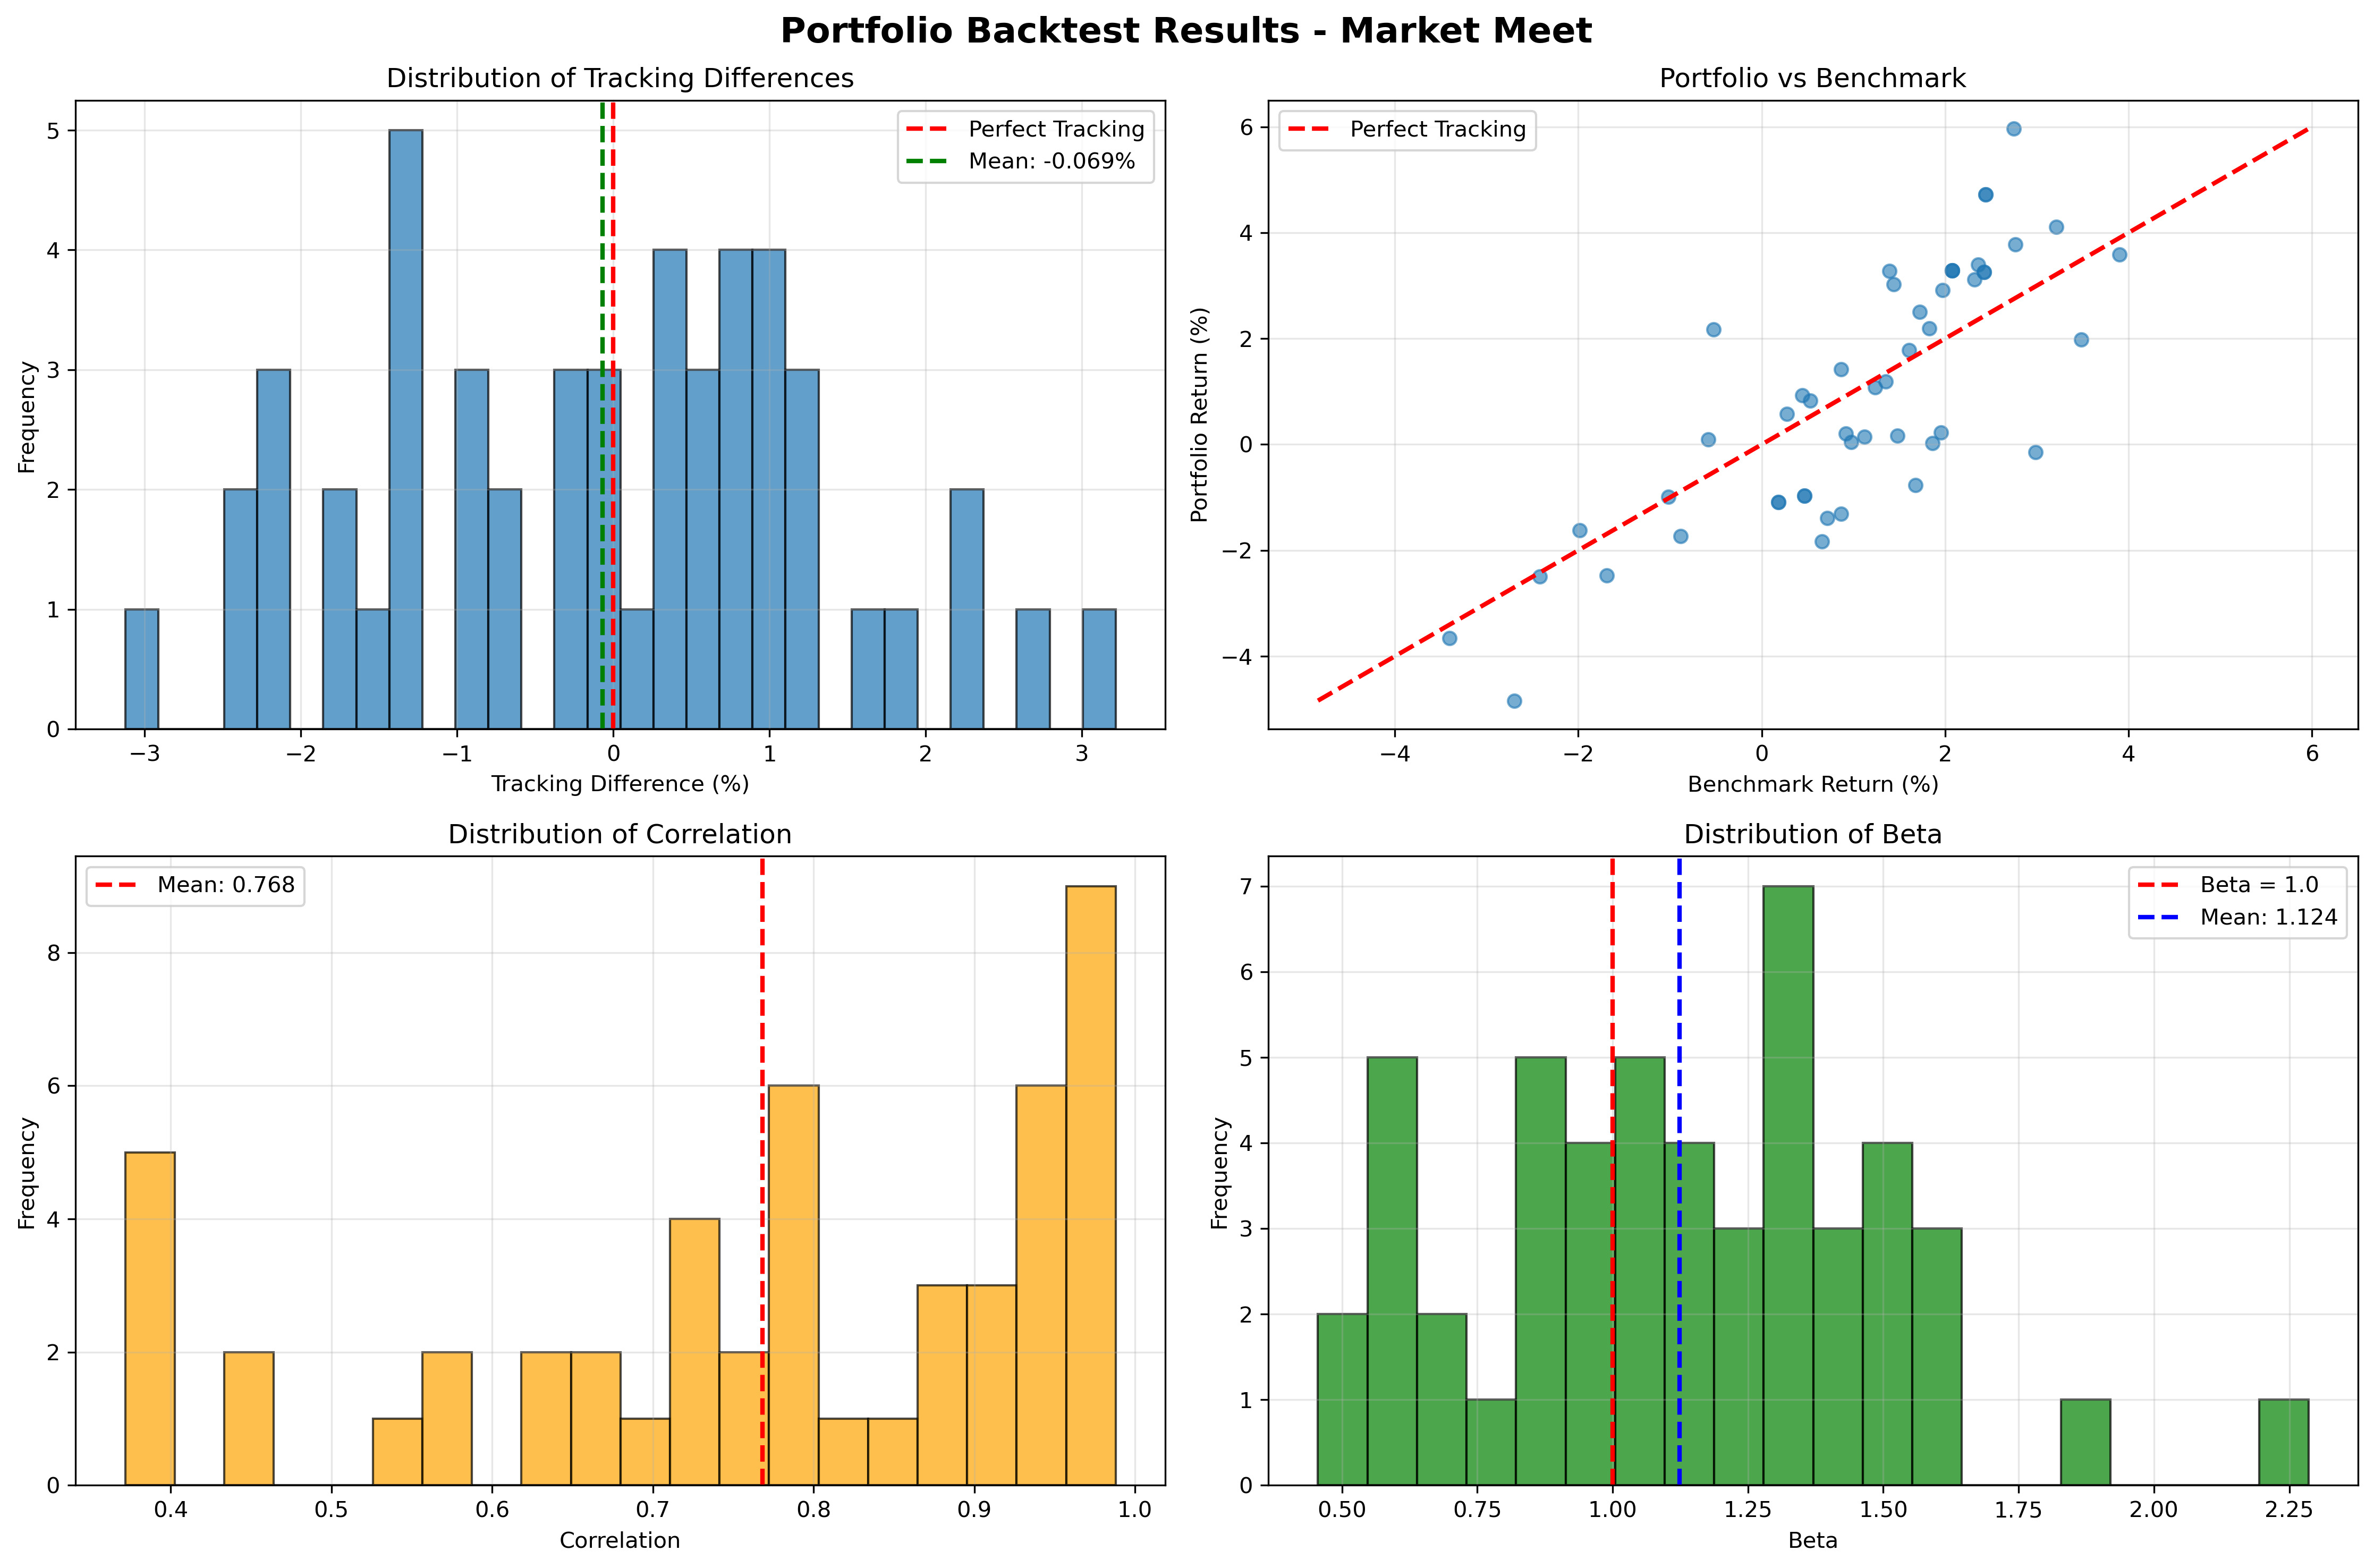

These visualizations indicate that correlation is the strongest and most reliable predictor of short-term benchmark tracking. The tracking difference histogram (top-left) shows that deviations lessen significantly when correlation is emphasized. The portfolio-vs-benchmark scatterplot (top-right) demonstrates that synchronization of daily movements (correlation) matters more than the absolute slope (beta). When looking at the distribution of correlation and beta, we see that the distribution of correlation is concentrated at 0.8-1.0, whereas the beta distribution is far noisier and spread. 

For the aforementioned reasons, we assigned correlation a dominant weight of 0.70 and beta a weight of 0.20.

## [CODE] Calculating Final Score

In [89]:
# Gathers all the computed metrics and converts them into a score
def score_calculate(valid_tickers):
    x = score_data(valid_tickers) # This contains the Beta, Correlation, Volatility, and stock's Sector
    final = {} # Stores scores 
    total_weight = 0.0 # Accumulates all the raw scores 

    w1, w2, w3 = 0.20, 0.70, 0.1 # Selected weights for beta, correlation, and volatility

    for ticker, m in x: # Loop through all the metrics for each stock
        beta = m['Beta']
        corr = m['Correlation']
        sigma_rel = m['Sigma_Rel'] # Note that sigma_rel is the comparison between the stock's volatility and the benchmark volatility

        # This stretches the sigma_rel ratio (which is normally between 0-1) into a larger range
        # This enhances accuracy when measuring volatility (volatility differences are more apparent)
        vol_ratio = sigma_rel / (1 - sigma_rel) if sigma_rel < 1 else 1.0

        # Formula to calculate the Euclidian distance from an idea stock
        # A smaller distance = higher score
        distance = np.sqrt(

            w1 * (beta - 1) ** 2 +
            w2 * (1 - corr) ** 2 +
            w3 * (vol_ratio - 1) ** 2
        )

        score = 1 / (1 + distance) # Smaller distances are converted to larger scores, and vice versa

        # Ignore NaN/infinte scores
        if not np.isfinite(score): 
            continue

        # The raw score temporarily acts as the weighting
        weight = score
        total_weight += weight

        # Store results
        final[ticker]= [float(np.round(score, 5)), m['Sector']]

    # Finally, we loop through all the stocks kept after scoring
    for i in final:
        score_value = final[i][0] # Retrieve raw scores 
        weight_in_percent = (score_value / total_weight) * 100 if total_weight != 0 else 0.0 # This converts the raw weighting into a percentage that adds up to 100% 
        # If the scores fail somehow, weights are set to 0 instead of leaving an error
        final[i].append(float(np.round(weight_in_percent, 5))) #Finally, attach each weighting with each stock
        

# We run every stock through ALL the helper functions that were made previously
    final = filter_out_low_weight_stocks(final)
    final = market_cap_filtering(final, x)
    final = add_defensive_layer(final, x, defensive_ratio=0.05)
    final = limit_portfolio_size(final, max_size=25, min_size=10)
    final = enforce_min_weight(final)
    final = apply_risk_constraints(final, max_position=15.0, max_sector=40.0)
    final = rebalance_currency_mix(final)

    return final


## [CODE] Creating Final Portfolio + Main

In [91]:
# Transforms all the finalized data into a portfolio
def create_portfolio_dataframe(final_portfolio, total_value_cad=1000000):
    # We make a portfolio with the size of $1,000,000 CAD by default
    
    portfolio_data = []

    # Loop through each ticker for the portfolio
    for ticker, data in final_portfolio.items():
        # We should be gathering the latest price
        try:
            stock = yf.Ticker(ticker)
            info = stock.get_info()
            price = info.get('currentPrice') or info.get('regularMarketPrice') # If the currentPrice is missing we use regularMarketPrice

            # If the price is still missing, take the last 5 days of price data
            if price is None:
                hist = stock.history(period="5d")
                if not hist.empty: # If that STILL doesn't exist, take the last recorded price
                    price = hist['Close'].iloc[-1]
                else: 
                    continue
            # If all else fails, move on and skip the ticker
        except:
            continue
        
        # Determine currency
        currency = "CAD" if ticker.endswith(".TO") else "USD"
        
        # Convert the weight % to a decimal
        weight_decimal = data['Weight_Percent'] / 100
        # Then we use the weighting to find a dollar value we invest for said stock
        allocation_cad = total_value_cad * weight_decimal
        
        # Convert to appropriate currency for shares calculation
        if currency == "USD":
            allocation_in_currency = allocation_cad / CAD_PER_USD # Change the currency to USD if it's a US stock
        # Otherwise keep it the same (it's a canadian stock)
        else: 
            allocation_in_currency = allocation_cad
        
        # Calculate shares to buy given the investment in the stock
        shares = round(allocation_in_currency / price, 4)
        
        # Calculate actual value in original currency
        value_in_currency = shares * price
        
        # Convert value to CAD
        value_cad = value_in_currency if currency == "CAD" else value_in_currency * CAD_PER_USD

        # Append all the info
        portfolio_data.append({
            'Ticker': ticker,
            'Price': round(price, 2),
            'Currency': currency,
            'Shares': shares,
            'Value': round(value_cad, 2),
            'Weight': round(data['Weight_Percent'], 2)
        })

    # Finally, we convert it all into a nice, clean pandas table
    df = pd.DataFrame(portfolio_data)
    df.index = range(1, len(df) + 1)
    
    return df

# We take the final portfolio, and only save the ticker and the number of Shares to buy into a CSV file

def save_stocks_csv(portfolio_df, group_number, directory="."):
    """Save Ticker and Shares to CSV"""
    stocks_df = portfolio_df[['Ticker', 'Shares']].copy() # Extracting only tickers and shares
    filename = f"{directory}/Stocks_Group_{group_number:02d}.csv" # Make file name
    stocks_df.to_csv(filename, index=False) # Save csv
    print(f"\nStocks CSV saved to: {filename}")
    return filename

# This finds the actual transaction fees based on fee rules

def calculate_actual_fees(portfolio_df):
    total_fees_usd = 0.0

    for _, row in portfolio_df.iterrows():
        shares = row['Shares']
        per_share_fee = shares * 0.001 # Shares either cost 0.001 a share or a maximum of $2.15
        fee = min(2.15, per_share_fee) # Whichever fee is lower
        total_fees_usd += fee # Fees added in USD and converts to CAD

    total_fees_cad = total_fees_usd * CAD_PER_USD
    return total_fees_cad

# Reads the tickers, filters them, scores them, builds a risk-balanced portfolio, 
# calculates fees, adjusts final weights, generates share counts, outputs the final portfolio, and saves a CSV 
def main():
    tickers_list = read_csv("Tickers.csv")
    valid, invalid = check_ticker(tickers_list)

    final_portfolio = score_calculate(valid)


    # Account for fees - calculate actual transaction fees
    TOTAL_PORTFOLIO_VALUE = 1000000  # $1M CAD

    # First pass: estimate fees with initial portfolio
    temp_portfolio_df = create_portfolio_dataframe(final_portfolio, TOTAL_PORTFOLIO_VALUE)
    actual_fees = calculate_actual_fees(temp_portfolio_df)
    available_to_invest = TOTAL_PORTFOLIO_VALUE - actual_fees

    # Create final portfolio DataFrame with correct investment amount
    portfolio_df = create_portfolio_dataframe(final_portfolio, available_to_invest)
    
    # Display Portfolio_Final DataFrame
    print("PORTFOLIO_FINAL")
    print()
    print(portfolio_df)
    
    # Calculate actual totals
    total_value = portfolio_df['Value'].sum()
    total_weight = portfolio_df['Weight'].sum()

    save_stocks_csv(portfolio_df, 13)
    
    print(f"\nTotal Portfolio Value: ${total_value:,.2f} CAD")
    print(f"Total Weight: {total_weight:.1f}%")
    print(f"Transaction Fees: ${actual_fees:,.2f} CAD")
    print(f"Cash Reserve (fees): ${TOTAL_PORTFOLIO_VALUE - total_value:,.2f} CAD")
    print(f"Portfolio + Cash: ${total_value + (TOTAL_PORTFOLIO_VALUE - total_value):,.2f} CAD")
    print()
if __name__ == "__main__":
    main()


$AGN: possibly delisted; no timezone found
$CELG: possibly delisted; no timezone found
$MON: possibly delisted; no timezone found
$RTN: possibly delisted; no timezone found
/var/folders/fp/yttkjwks0hqdpssrf8qtp_wc0000gn/T/ipykernel_87268/20388546.py:64: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(["^GSPC", "^GSPTSE"], start=start, end=end)["Close"]
[*********************100%***********************]  2 of 2 completed
/var/folders/fp/yttkjwks0hqdpssrf8qtp_wc0000gn/T/ipykernel_87268/20388546.py:66: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = blended_price.pct_change().dropna()
[*********************100%***********************]  1 of 1 completed
/var/folders/fp/yttkjwks0hqdpssrf8qtp_wc0000gn/T/ipykernel_87268/3344655368.py:70: F

PORTFOLIO_FINAL

   Ticker    Price Currency      Shares      Value  Weight
1   BB.TO     5.89      CAD  31843.8258  187560.13   18.76
2   RY.TO   211.38      CAD    739.0357  156217.37   15.62
3   TD.TO   115.59      CAD   1351.4782  156217.37   15.62
4     CAT   550.43      USD     37.7888   29309.82    2.93
5    AAPL   271.49      USD     73.1307   27977.03    2.80
6    AMZN   220.69      USD     89.5457   27846.80    2.78
7    QCOM   163.30      USD    118.7880   27334.22    2.73
8     ACN   251.85      USD     76.8296   27265.82    2.73
9     UPS    94.66      USD    202.6783   27034.71    2.70
10    UNP   226.22      USD     84.3606   26891.72    2.69
11    UNH   319.97      USD     59.5572   26852.92    2.69
12    PFE    25.04      USD    758.5830   26766.12    2.68
13    BMY    46.25      USD    396.5324   25842.73    2.58
14    LLY  1059.70      USD     17.1582   25621.39    2.56
15     BA   179.70      USD    100.9772   25569.33    2.56
16    LMT   460.78      USD     38.9932

# Contribution Declaration

The following team members made a meaningful contribution to this assignment:
Jaimin Patel, Frank Lin, Elliot Nou

# References

Government of Canada, Statistics Canada. (2025, November 17). Consumer price index, monthly, not seasonally adjusted. Consumer Price Index, monthly, not seasonally adjusted. https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000401 

Leote de Carvalho, R., Xiao, Y., & Moulin, P. (2014). The portfolio of risk premia: A new approach to diversification. SSRN Electronic Journal. https://doi.org/10.2139/ssrn.2404740

Portfolio of risk premia: A new approach to diversification. (n.d.). https://www.fiapinternacional.org/prontus_noticia/site/artic/20090619/asocfile/20090619154913/portfolio_of_risk_premia_a_new_approach_to_diversification_1.pdf 


U.S. Bureau of Labor Statistics. (2025, October 24). Consumer price index summary - 2025 M09 results. U.S. Bureau of Labor Statistics. https://www.bls.gov/news.release/cpi.nr0.htm 